Gold Ore Production - Zyfra

- <a href='#1'>1. Data Preliminaries</a>
    - <a href='#1.1'>1.1. Import Libraries </a>
    - <a href='#1.2'>1.2. Loading Data </a>
- <a href='#2'>2. EDA </a>
    - <a href='#2.1'>2.1. Checking for Duplicates </a>
    - <a href='#2.2'>2.2. Checking for Missing Values </a>
    - <a href='#2.3'>2.3. Scaling the Data </a>
    - <a href='#2.4'>2.4. Treating Missing Values </a>
- <a href='#3'>3. Feature Engineering </a>
    - <a href='#3.1'>3.1. Change in Metal Concentration by Purification Stage</a>
    - <a href='#3.2'>3.2. Distribution of Primer Cleaner and Rougher Input Feed Size Values </a>
    - <a href='#3.3'>3.3. Total Concentration of All Metals by stage </a>
- <a href='#4'>4. Data Preparation by ML</a>
    - <a href='#4.1'>4.1. sMAPE</a>
    - <a href='#4.2'>4.2. Splitting the Dataset</a>
- <a href='#5'>5. Linear Regression Models</a>
    - <a href='#5.1'>5.1. Decision Tree Regressor</a>
    - <a href='#5.2'>5.2. Linear Regressor </a>
    - <a href='#5.3'>5.3. Lasso Regressor</a>
    - <a href='#5.4'>5.4. KNeigbors Regressor</a>
- <a href='#6'>6. Summary of Best Score Linear Regression Models </a> 
- <a href='#7'>7. Evaluation Model </a> 
    - <a href='#7.1'>7.1. Cross-Validation </a>
    - <a href='#7.2'>7.2. Sanitation Check </a>
- <a href='#8'>8. Conclusion</a>

# Data Preliminaries

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from numpy.random import RandomState
from pprint import pprint
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
try: 
    gold_train = pd.read_csv('gold_recovery_train.csv')
    gold_test = pd.read_csv('gold_recovery_test.csv')
    gold_full = pd.read_csv('gold_recovery_full_new.csv')

except:
    gold_train = pd.read_csv('/datasets/gold_recover_train.csv')
    gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
    gold_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
#Create function to calculate Recovery.
def recovery(df, C, F, T):
    rec = 100 * ((df[C] * (df[F] - df[T])) / (df[F] * (df[C] - df[T])))
    return rec

#Carry out calculations for rows which don't have NaN in rougher.output.recovery.
vals_pred = recovery(gold_train.dropna(subset=['rougher.output.recovery']), 'rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au')
vals_act = gold_train['rougher.output.recovery'].dropna().to_list()

print(f"Mean Absolute Error: {mean_absolute_error(vals_act, vals_pred)}")

Mean Absolute Error: 9.303415616264301e-15


In [4]:
not_in_gold_test = [x for x in gold_full.columns if x not in gold_test.columns]
pprint(not_in_gold_test)

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [5]:
gold_test = pd.merge(gold_test, gold_full[['date', 'final.output.recovery', 'rougher.output.recovery']], on='date', how='left')

gold_train = gold_train.drop(columns=[x for x in gold_train if x not in gold_test], axis=1)

gold_test = gold_test.drop(columns=[x for x in gold_test if x not in gold_train], axis=1)

# EDA

In [6]:
print(gold_test.info())
print()
print(gold_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5856 entries, 0 to 5855
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

### Checking for Duplicates

In [7]:
print(f"Duplicates in the gold_train dataset: {gold_train.duplicated().sum()}")
print(f"Duplicates in the gold_test dataset: {gold_test.duplicated().sum()}")

Duplicates in the gold_train dataset: 0
Duplicates in the gold_test dataset: 0


### Checking for Missing Values

In [8]:
def missing_values(data):
  df = pd.DataFrame()
  for col in list(data):
    unique_values = data[col].unique()
    try:
      unique_values = np.sort(unique_values)
    except:
      pass
    nans = round(pd.isna(data[col]).sum()/data.shape[0]*100, 1)
    zeros = round((data[col] == 0).sum()/data.shape[0]*100, 1)

    df = df.append(pd.DataFrame([col, len(unique_values), nans,  zeros]).T, ignore_index = True)
  return df.rename(columns = {0: 'variable',
1: 'Unique values',
2: 'Nan %',
3: 'zeros %',
4: 'empty'}).sort_values('Nan %', ascending=False)

In [9]:
missing_values(gold_test)

,variable,Unique values,Nan %,zeros %
54,rougher.output.recovery,5188,9.7,1.7
53,final.output.recovery,5230,9.7,0.7
22,rougher.input.floatbank11_xanthate,5504,6.0,0.0
1,primary_cleaner.input.sulfate,5555,5.2,0.0
2,primary_cleaner.input.depressant,5573,4.8,0.0
19,rougher.input.floatbank10_sulfate,5600,4.4,0.0
4,primary_cleaner.input.xanthate,5691,2.8,0.0
20,rougher.input.floatbank10_xanthate,5734,2.1,0.0
17,rougher.input.feed_sol,5413,1.1,6.3
21,rougher.input.floatbank11_sulfate,5802,0.9,0.0


In [10]:
missing_values(gold_train)

,variable,Unique values,Nan %,zeros %
24,rougher.output.recovery,13946,15.3,1.9
23,rougher.input.floatbank11_xanthate,14942,11.3,0.0
1,final.output.recovery,14767,9.0,0.5
2,primary_cleaner.input.sulfate,15554,7.8,0.0
3,primary_cleaner.input.depressant,15541,7.5,0.3
20,rougher.input.floatbank10_sulfate,15817,6.2,0.0
5,primary_cleaner.input.xanthate,15876,5.8,0.0
22,rougher.input.floatbank11_sulfate,16238,3.7,0.0
33,rougher.state.floatbank10_e_air,16253,3.6,0.0
16,rougher.input.feed_rate,16348,3.0,0.0


In [11]:
missing_values(gold_full)

,variable,Unique values,Nan %,zeros %
67,secondary_cleaner.output.tail_sol,16832,9.0,4.4
43,rougher.input.floatbank11_xanthate,18972,2.3,0.0
61,rougher.state.floatbank10_e_air,19004,2.2,0.0
16,primary_cleaner.output.concentrate_sol,18827,1.9,0.6
69,secondary_cleaner.state.floatbank2_a_air,19219,1.1,0.0
...,...,...,...,...
32,rougher.calculation.floatbank11_sulfate_to_au_...,19438,0.0,0.0
31,rougher.calculation.floatbank10_sulfate_to_au_...,19438,0.0,0.0
30,rougher.calculation.sulfate_to_au_concentrate,19438,0.0,0.0
29,primary_cleaner.state.floatbank8_d_level,19439,0.0,0.0


### Scaling the Data

In [12]:
scaler = MinMaxScaler()

scale_columns = [x for x in gold_train.columns if x  not in ['date', 'rougher.output.recovery', 'final.output.recovery']]
non_scale_columns = ['date', 'rougher.output.recovery', 'final.output.recovery']

gold_train_scaled = pd.DataFrame(scaler.fit_transform(gold_train[scale_columns].copy()), columns = scale_columns)
gold_test_scaled = pd.DataFrame(scaler.transform(gold_test[scale_columns].copy()), columns = scale_columns)

### Treating Missing Values

In [13]:
%%time
imputer = KNNImputer()

gold_train_scaled = pd.concat([gold_train[non_scale_columns]] + \
                              [pd.DataFrame(imputer.fit_transform(gold_train_scaled), \
                               columns=gold_train_scaled.columns)], axis = 1)

gold_test_scaled = pd.concat([gold_test[non_scale_columns]] + \
                             [pd.DataFrame(imputer.transform(gold_test_scaled), \
                              columns=gold_test_scaled.columns)], axis = 1)

CPU times: user 12 s, sys: 1.1 s, total: 13.1 s
Wall time: 9.9 s


In [14]:
print(f"Rows with NaNs in the gold_train_scaled dataset: {gold_train_scaled.isnull().any(axis=1).sum()}")
print(f"Percent of rows with NaNs in one or both targets in gold_train_scaled dataset: {round(100 * (gold_train_scaled.isnull().any(axis=1).sum()) / len(gold_train_scaled), 2)}\n")
print(f"Rows with NaNs in the gold_test_scaled dataset: {gold_test_scaled.isna().any(axis=1).sum()}")
print(f"Percent of rows with NaNs in one or both targets in gold_test_scaled dataset: {round(100 * (gold_test_scaled.isnull().any(axis=1).sum()) / len(gold_test_scaled), 2)}")

Rows with NaNs in the gold_train_scaled dataset: 2711
Percent of rows with NaNs in one or both targets in gold_train_scaled dataset: 16.08

Rows with NaNs in the gold_test_scaled dataset: 566
Percent of rows with NaNs in one or both targets in gold_test_scaled dataset: 9.67


In [15]:
gold_train_scaled = gold_train_scaled.dropna().reset_index(drop=True)
gold_test_scaled = gold_test_scaled.dropna().reset_index(drop=True)

## Feature Engineering

### Change in Metal Concentration by Purification Stage

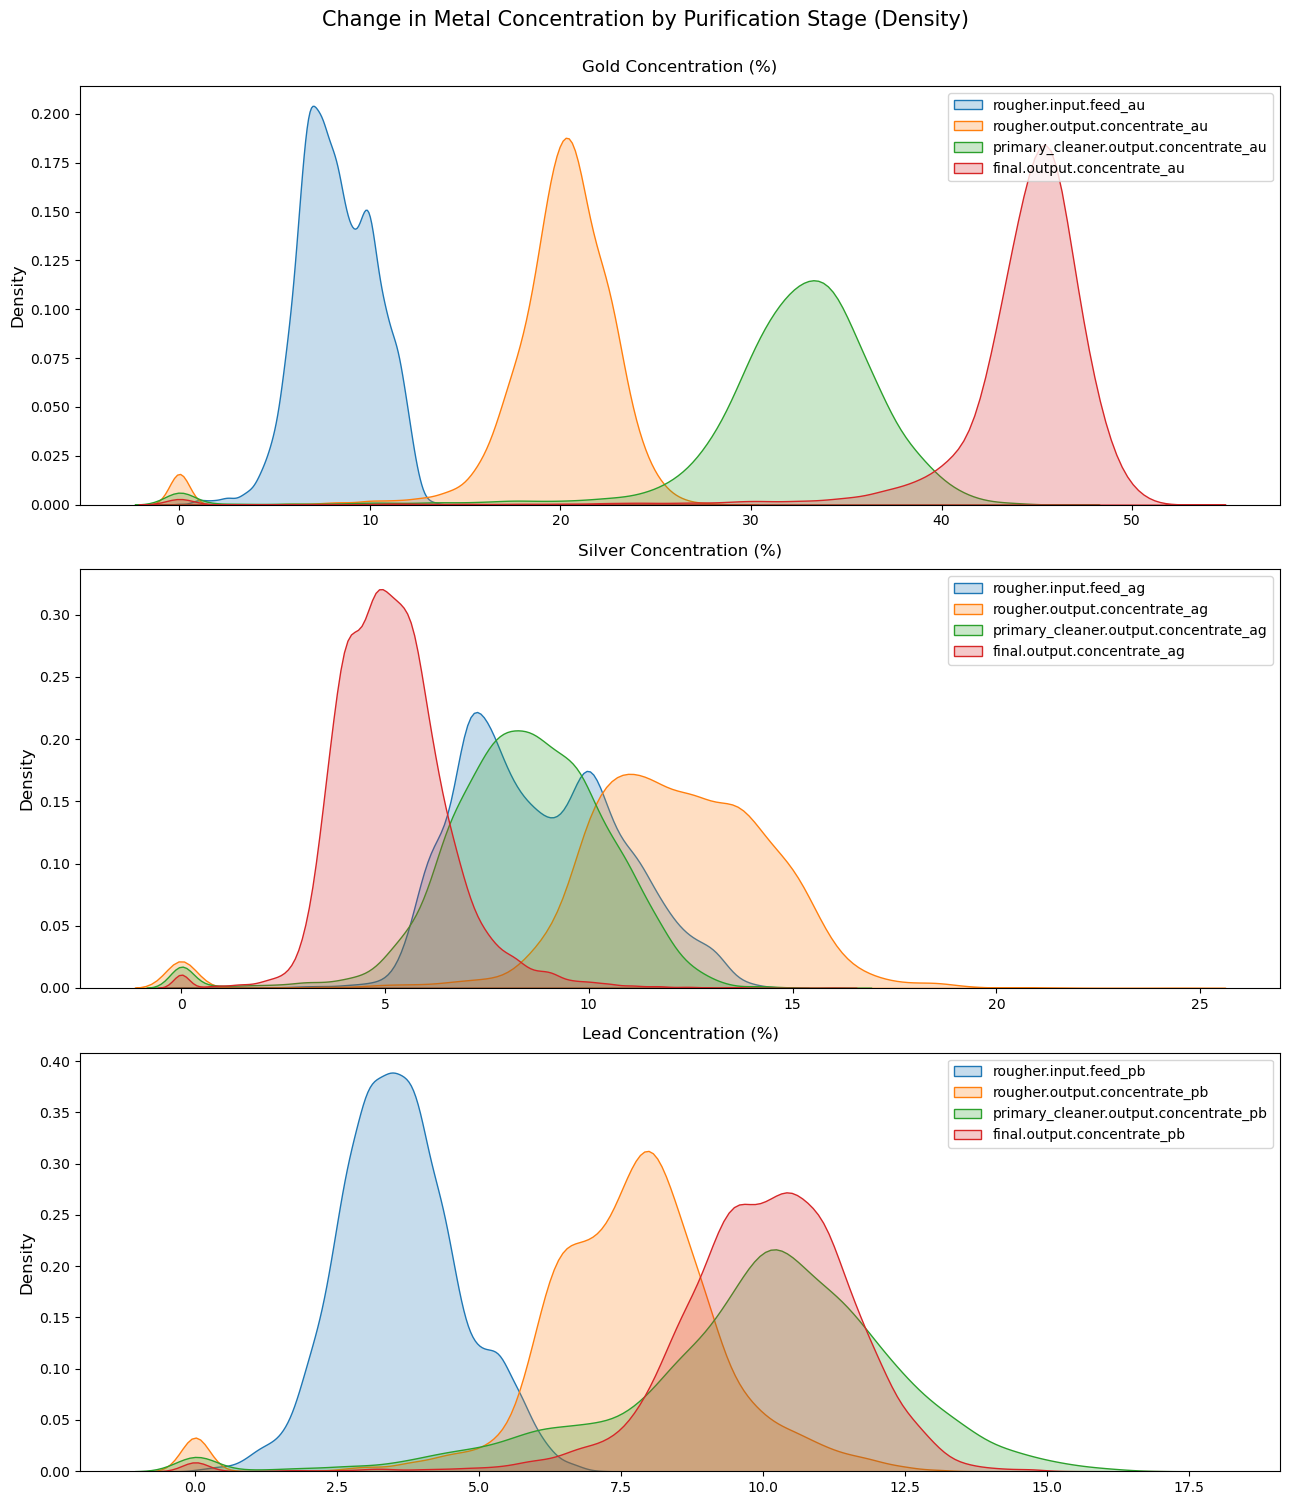

In [16]:
concen = ["rougher.input.feed", "rougher.output.concentrate", "primary_cleaner.output.concentrate", "final.output.concentrate"]

metals = {'_au' : 'Gold', '_ag' : 'Silver', '_pb' : 'Lead'}

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(13, 15), sharey=False)
fig.suptitle('Change in Metal Concentration by Purification Stage (Density)', fontsize=15, y=1)

for x in metals.keys():
    for c in concen:
        ax = list(metals.keys()).index(x)
        sns.kdeplot(gold_full[(c+x)], ax=axes[ax], shade='fill', label=(c+x))
        axes[ax].legend()
        axes[ax].set_xlabel(metals[x] + ' Concentration (%)', fontsize=12, labelpad = 10)
        axes[ax].xaxis.set_label_position('top')
        axes[ax].set_ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()

### Distribution of Primary Cleaner and Rougher Input Feed_Size Values

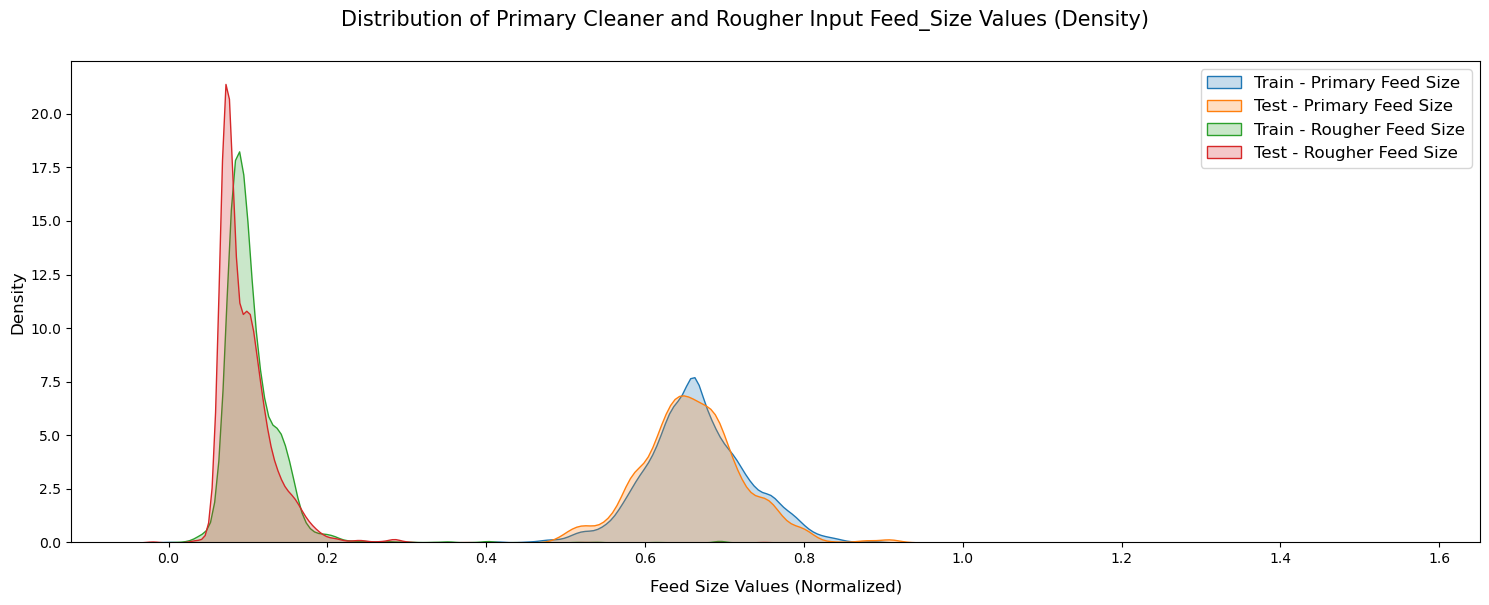

In [17]:
fig = plt.figure(figsize=(15, 6))
fig.suptitle('Distribution of Primary Cleaner and Rougher Input Feed_Size Values (Density)', fontsize=15, y=1)

sns.kdeplot(gold_train_scaled['primary_cleaner.input.feed_size'], fill=True, label='Train - Primary Feed Size')
sns.kdeplot(gold_test_scaled['primary_cleaner.input.feed_size'], fill=True, label='Test - Primary Feed Size')
sns.kdeplot(gold_train_scaled['rougher.input.feed_size'], fill=True, label='Train - Rougher Feed Size')
sns.kdeplot(gold_test_scaled['rougher.input.feed_size'], fill=True, label='Test - Rougher Feed Size')
plt.legend(fontsize=12)
plt.xlabel('Feed Size Values (Normalized)', fontsize=12, labelpad = 10)
plt.ylabel('Density', fontsize=12)
    
plt.tight_layout()
plt.show()

### Total Concentration of All Metals by Stage

In [18]:
def metal_concen_sum(df, stage):
    metal_handles = list(metals.keys())
    total_concen = df[stage+metal_handles[0]] + df[stage+metal_handles[1]] + df[stage+metal_handles[2]]
    return total_concen

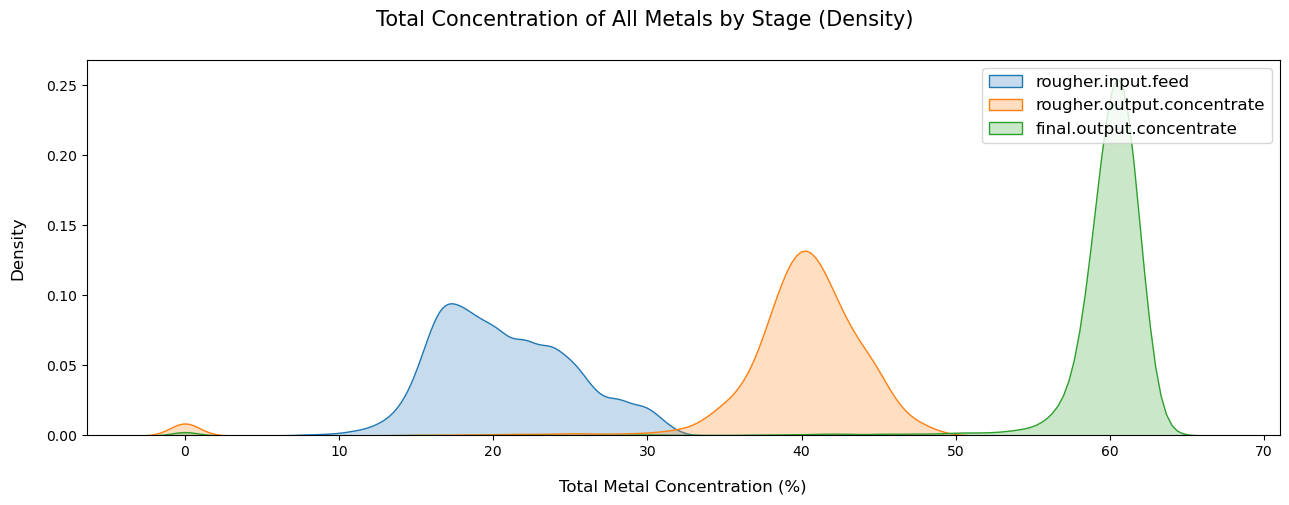

In [19]:
fig = plt.figure(figsize=(13, 5))
fig.suptitle('Total Concentration of All Metals by Stage (Density)', fontsize=15, y=1)

sns.kdeplot(metal_concen_sum(gold_full, 'rougher.input.feed'), label='rougher.input.feed', fill=True)
sns.kdeplot(metal_concen_sum(gold_full, 'rougher.output.concentrate'), label='rougher.output.concentrate', fill=True)
sns.kdeplot(metal_concen_sum(gold_full, 'final.output.concentrate'), label='final.output.concentrate', fill=True)
plt.legend(fontsize=12)
plt.xlabel('Total Metal Concentration (%)', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
    
plt.tight_layout()
plt.show()

In [20]:
gold_full_no_outliers = gold_full.loc[(gold_full[['rougher.input.feed_au', 'rougher.input.feed_pb', \
                                               'rougher.input.feed_ag']].sum(axis=1) > 10) \
                                  & (gold_full[['rougher.output.concentrate_au', 'rougher.output.concentrate_pb', \
                                                 'rougher.output.concentrate_ag']].sum(axis=1) > 10) \
                                  & (gold_full[['final.output.concentrate_au', 'final.output.concentrate_pb', \
                                                'final.output.concentrate_ag']].sum(axis=1) > 10)]

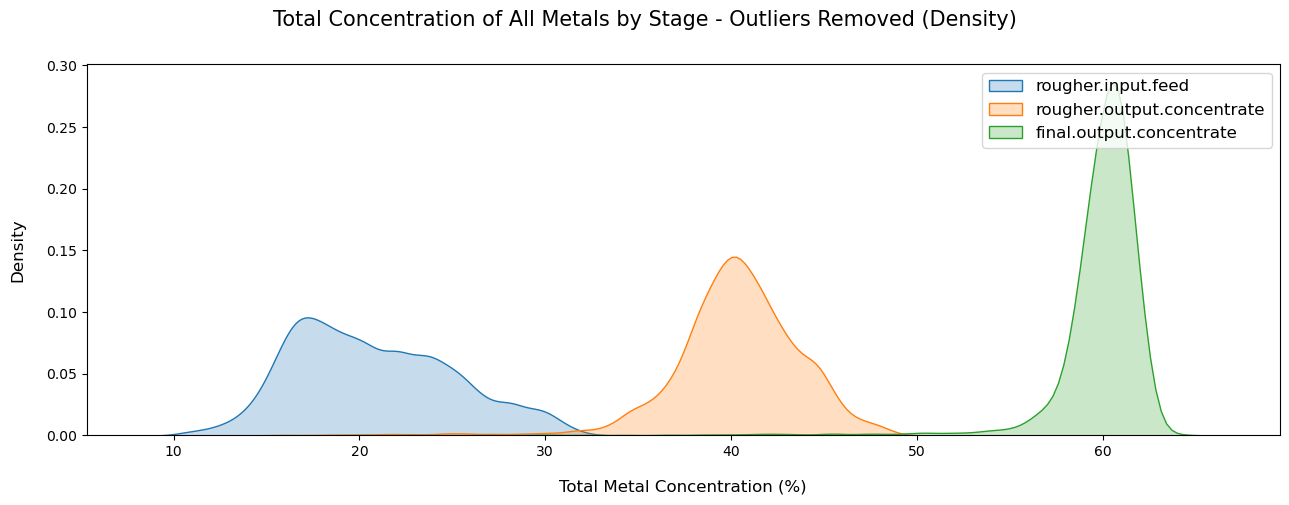

In [21]:
fig = plt.figure(figsize=(13, 5))
fig.suptitle('Total Concentration of All Metals by Stage - Outliers Removed (Density)', fontsize=15, y=1)

sns.kdeplot(metal_concen_sum(gold_full_no_outliers, 'rougher.input.feed'), label='rougher.input.feed', fill=True)
sns.kdeplot(metal_concen_sum(gold_full_no_outliers, 'rougher.output.concentrate'), label='rougher.output.concentrate', fill=True)
sns.kdeplot(metal_concen_sum(gold_full_no_outliers, 'final.output.concentrate'), label='final.output.concentrate', fill=True)
plt.legend(fontsize=12)
plt.xlabel('Total Metal Concentration (%)', fontsize=12, labelpad = 15)
plt.ylabel('Density', fontsize=12, labelpad=15)
    
plt.tight_layout()
plt.show()

In [22]:
total_before = [len(gold_train_scaled), len(gold_test_scaled)]

gold_train_scaled = gold_train_scaled.loc[gold_train_scaled['date'].isin(gold_full_no_outliers['date'])].reset_index(drop=True)
gold_test_scaled = gold_test_scaled.loc[gold_test_scaled['date'].isin(gold_full_no_outliers['date'])].reset_index(drop=True)

display(pd.DataFrame([[total_before[0], len(gold_train_scaled), round((100 - (len(gold_train_scaled) / total_before[0]) * 100), 2)], \
                      [total_before[1], len(gold_test_scaled), round((100 - (len(gold_test_scaled) / total_before[1]) * 100), 2)]], \
                    columns = ['Initial Length', 'New Length', 'Difference (%)'], index=['Gold Train', 'Gold Test']))

,Initial Length,New Length,Difference (%)
Gold Train,14149,13650,3.53
Gold Test,5290,5133,2.97


## Data Preparation for ML

### sMAPE

In [23]:
def smape2(y_true, y_pred):
    smape = np.mean(abs(y_pred - y_true) / ((abs(y_true) + abs(y_pred)) / 2)) * 100 
    return smape

def f_smape(y_true, y_pred):
    predicted_rough, predicted_final = y_pred[:, 0], y_pred[:, 1]
    true_rough, true_final = y_true[:, 0], y_true[:, 1]
    f_smape = (.25 * (smape2(true_rough, predicted_rough))) + (.75 * (smape2(true_final, predicted_final)))
    return f_smape


### Splitting the Dataset

In [24]:
targets = ['rougher.output.recovery', 'final.output.recovery']
features = [x for x in gold_train_scaled if x not in targets and x != 'date']

y_train, y_test = gold_train_scaled[targets].values, gold_test_scaled[targets].values
X_train, X_test = gold_train_scaled[features].values, gold_test_scaled[features].values

## Linear Regression Models

In [25]:
smape = make_scorer(f_smape, greater_is_better=False)

def train_fit_score(model, params, name):
    model = GridSearchCV(model, param_grid=params, cv=5, scoring=smape, verbose=0, refit=True)
    model.fit(X_train, y_train)
    return pd.DataFrame([[name, abs(model.best_score_), model.best_params_]], columns=['Estimator', 'Best Score', 'Best Params'])

### Decision Tree Regressor

In [26]:
%%time
DecisionTree = train_fit_score(DecisionTreeRegressor(random_state=12345), \
                      {'max_depth': range(5, 10, 5), \
                       'min_impurity_decrease' : np.arange(.01, .20, .02), \
                       'min_samples_split' : range(1, 10, 2)}, 'Decision Tree')

CPU times: user 49.7 s, sys: 15.7 ms, total: 49.7 s
Wall time: 49.9 s


### Linear Regressor

In [27]:
%%time
LinearRegressor = train_fit_score(LinearRegression(), {}, 'Linear Regressor')

CPU times: user 583 ms, sys: 44 ms, total: 627 ms
Wall time: 752 ms


### Lasso Regressor

In [28]:
%%time
LassoRegressor = train_fit_score(Lasso(random_state=12345), \
                        {'alpha' : np.arange(.01, 1, .05)}, 'Lasso Regressor')

CPU times: user 5.34 s, sys: 172 ms, total: 5.51 s
Wall time: 1.39 s


### KNeighbors Regressor

In [29]:
%%time
KNNeighbors = train_fit_score(KNeighborsRegressor(), 
                        {'n_neighbors' : range(2, 10, 1),
                         'weights' : ['uniform', 'distance']}, 'KNeighbors Regressor')

CPU times: user 1min 13s, sys: 18.9 s, total: 1min 32s
Wall time: 27.2 s


## Summary of Best Scores - Linear Regression Models

In [30]:
scores = pd.concat([DecisionTree, LinearRegressor, LassoRegressor, KNNeighbors]).set_index('Estimator')
scores['Best Score'] = scores['Best Score'].round(2)
display(scores.drop('Best Params', axis=1))

,Best Score
Estimator,
Decision Tree,9.18
Linear Regressor,10.01
Lasso Regressor,8.51
KNeighbors Regressor,9.74


## Evaluation Model

### Cross-Validation

In [31]:
regressors = [DecisionTreeRegressor(**scores['Best Params'][0]), LinearRegression(**scores['Best Params'][1]), \
              Lasso(**scores['Best Params'][2]), KNeighborsRegressor(**scores['Best Params'][3])]

cv_scores = []

for regressor in regressors:
    temp_score = abs(cross_val_score(regressor, X_train, y_train, cv=5, scoring=smape, verbose=0))
    cv_scores.append(round(np.mean(temp_score), 2))

In [32]:
display(pd.DataFrame(cv_scores, columns=['Cross Val. Scores'], index=scores.index))

,Cross Val. Scores
Estimator,
Decision Tree,9.18
Linear Regressor,10.01
Lasso Regressor,8.51
KNeighbors Regressor,9.74


In [33]:
best_model = Lasso(**scores['Best Params'][2]).fit(X_train, y_train)

Lasso_smape = round(f_smape(y_test, best_model.predict(X_test)), 2)

print(f'sMAPE score for best Lasso Regressor model on test datasets: {Lasso_smape}')

sMAPE score for best Lasso Regressor model on test datasets: 6.28


### Sanity Check

In [34]:
smape_sanity = f_smape(y_test, np.tile(np.mean(y_train, axis=0), (len(y_test), 1)))
print(f'sMAPE score for sanity check model: {round(smape_sanity, 2)}')

sMAPE score for sanity check model: 7.54


## Conclusion

The objective of this project was to develop a prototype model that utilizes extraction and purification data to predict the amount of gold that can be recovered from gold ore. To achieve this goal, we executed several pre-processing and data analysis steps. Firstly, we performed data pre-processing activities such as identifying and eliminating duplicates, scaling the data, filling missing values, and adding target values to the testing dataset. Subsequently, we analyzed the data, focusing on the concentration of metals at various stages, and visualized the total concentration of all metals after key processes. Additionally, we investigated the similarity of feed particle sizes in the training and testing datasets, and identified and removed outliers.

Afterwards, we developed functions to compute the final sMAPE score from predictions and target values, and trained various regression estimators. By selecting the estimator that provided the lowest sMAPE score, we obtained the score for the testing dataset using the optimal parameters. Finally, we compared our score with the score provided by a sanity 'model'.

Although our best model performed relatively well with a sMAPE score of approximately 6.28 percent, we tested our model against a sanity 'model' to obtain a more precise evaluation of our model's performance. The sMAPE score of the sanity 'model' was 7.54 percent, which is more than 1 percent higher than our score using the testing dataset. However, it is also lower than the score we obtained on the training dataset. This may be due to the non-random selection of samples for each set, which could have resulted in an unfair advantage being given to one set. To address this, we suggest retraining and testing with randomized datasets.

Although our models did not provide a sMAPE score significantly lower than the sanity 'model's' score, we understand that optimizing the gold-extraction process is essential for Zyfra's operations. Therefore, we recommend carefully examining the features in the gold_full dataset and organizing them by importance, perhaps by correlating them with target values. We suggest selecting only the most important features and collecting more data to train and test regression models again. It is possible that by using weighted features, a model can be obtained that provides a much lower sMAPE score than the sanity 'model's'.